# From Equation Graphs to Backpropagation

In this notebook, we'll take a journey from simple mathematical expressions to understanding how **backpropagation** works in neural networks. By the end, you'll understand:

1. **What is a computational/equation graph?**
2. **What are derivatives and why do we need them?**
3. **The Chain Rule - the heart of backpropagation**
4. **How to build an automatic differentiation engine**
5. **Using gradients to optimize values**

Let's begin!

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For visualization
from graphviz import Digraph

---
## Part 1: Derivatives - The Rate of Change

Before we dive into computational graphs, we need to understand **derivatives**.

A derivative tells us: *"If I change the input slightly, how much does the output change?"*

### Example: A Simple Function

Consider the function: $f(x) = 3x^2 - 4x + 5$

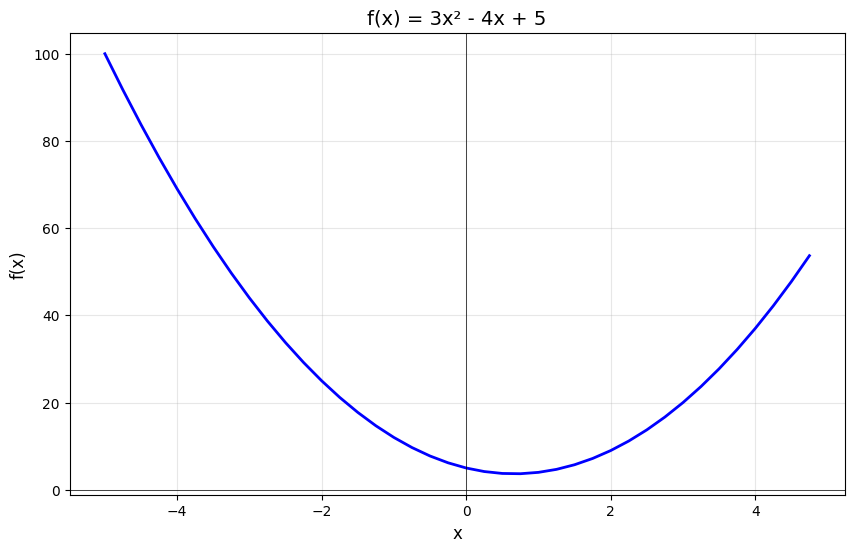

In [10]:
def f(x):
    """A simple quadratic function"""
    return 3*x**2 - 4*x + 5

# Let's visualize it
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'b-', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title('f(x) = 3x² - 4x + 5', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.show()

### Computing the Derivative Numerically

The derivative at a point $x$ can be approximated using:

$$\frac{df}{dx} \approx \frac{f(x + h) - f(x)}{h}$$

where $h$ is a very small number (like 0.0001).

This is called the **numerical derivative** or **finite difference approximation**.

In [11]:
def numerical_derivative(func, x, h=0.0001):
    """Compute the numerical derivative of func at point x"""
    return (func(x + h) - func(x)) / h

# Let's compute the derivative at different points
test_points = [-2, 0, 2/3, 2, 4]

print("Point x\t\t| f(x)\t\t| df/dx (numerical)\t| df/dx (analytical: 6x-4)")
print("-" * 80)

for x in test_points:
    fx = f(x)
    df_numerical = numerical_derivative(f, x)
    df_analytical = 6*x - 4  # The actual derivative of 3x² - 4x + 5 is 6x - 4
    print(f"{x:.4f}\t\t| {fx:.4f}\t| {df_numerical:.6f}\t\t| {df_analytical:.6f}")

Point x		| f(x)		| df/dx (numerical)	| df/dx (analytical: 6x-4)
--------------------------------------------------------------------------------
-2.0000		| 25.0000	| -15.999700		| -16.000000
0.0000		| 5.0000	| -3.999700		| -4.000000
0.6667		| 3.6667	| 0.000300		| 0.000000
2.0000		| 9.0000	| 8.000300		| 8.000000
4.0000		| 37.0000	| 20.000300		| 20.000000


### Key Insight: The Minimum

Notice that at $x = 2/3 = 0.6667$, the derivative is approximately **0**!

This is where the function has a **minimum** - the point where increasing or decreasing $x$ both lead to higher function values.

**This is the core idea behind optimization: find where the derivative is zero!**

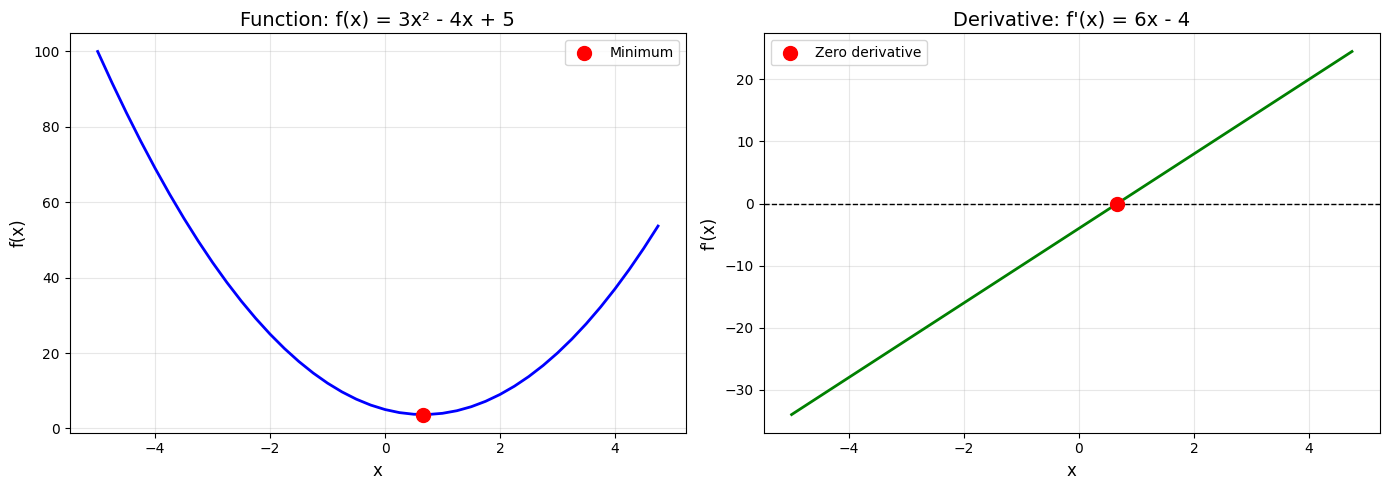

In [12]:
# Visualizing the derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the function
ax1.plot(xs, ys, 'b-', linewidth=2)
ax1.scatter([2/3], [f(2/3)], color='red', s=100, zorder=5, label='Minimum')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('f(x)', fontsize=12)
ax1.set_title('Function: f(x) = 3x² - 4x + 5', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot the derivative
dys = 6*xs - 4  # Analytical derivative
ax2.plot(xs, dys, 'g-', linewidth=2)
ax2.axhline(y=0, color='k', linewidth=1, linestyle='--')
ax2.scatter([2/3], [0], color='red', s=100, zorder=5, label='Zero derivative')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel("f'(x)", fontsize=12)
ax2.set_title("Derivative: f'(x) = 6x - 4", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

---
## Part 2: Multi-Variable Expressions - The Need for Graphs

Real neural networks have many variables. Let's consider a simple expression with multiple variables:

$$L = (a \cdot b + c) \cdot f$$

Here:
- $a$, $b$, $c$, $f$ are inputs
- $L$ is our final output (think: "Loss")

We want to know: **How does each input affect the final output $L$?**

In [13]:
# Let's compute this step by step
a = 2.0
b = -3.0
c = 10.0
f = -2.0

# Breaking down the computation:
e = a * b     # First: multiply a and b
d = e + c     # Then: add c
L = d * f     # Finally: multiply by f

print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
print(f"f = {f}")
print(f"---")
print(f"e = a * b = {a} * {b} = {e}")
print(f"d = e + c = {e} + {c} = {d}")
print(f"L = d * f = {d} * {f} = {L}")

a = 2.0
b = -3.0
c = 10.0
f = -2.0
---
e = a * b = 2.0 * -3.0 = -6.0
d = e + c = -6.0 + 10.0 = 4.0
L = d * f = 4.0 * -2.0 = -8.0


### Computing Partial Derivatives Using the "Wiggle" Method

How does each input affect $L$? Let's find out by "wiggling" each input slightly:

In [14]:
def compute_L(a, b, c, f):
    """Compute L = (a*b + c) * f"""
    return (a * b + c) * f

h = 0.0001  # Small perturbation

# Base values
a, b, c, f = 2.0, -3.0, 10.0, -2.0
L_base = compute_L(a, b, c, f)

# Derivative with respect to each variable
dL_da = (compute_L(a + h, b, c, f) - L_base) / h
dL_db = (compute_L(a, b + h, c, f) - L_base) / h
dL_dc = (compute_L(a, b, c + h, f) - L_base) / h
dL_df = (compute_L(a, b, c, f + h) - L_base) / h

print("Partial Derivatives (how much L changes when each input changes):")
print(f"∂L/∂a = {dL_da:.4f}")
print(f"∂L/∂b = {dL_db:.4f}")
print(f"∂L/∂c = {dL_dc:.4f}")
print(f"∂L/∂f = {dL_df:.4f}")

Partial Derivatives (how much L changes when each input changes):
∂L/∂a = 6.0000
∂L/∂b = -4.0000
∂L/∂c = -2.0000
∂L/∂f = 4.0000


### What Do These Derivatives Mean?

- **∂L/∂a = 6.0**: If we increase $a$ by 1, $L$ increases by 6
- **∂L/∂b = -4.0**: If we increase $b$ by 1, $L$ decreases by 4 (because gradient is negative)
- **∂L/∂c = -2.0**: If we increase $c$ by 1, $L$ decreases by 2
- **∂L/∂f = 4.0**: If we increase $f$ by 1, $L$ increases by 4

**If we want to DECREASE L, we should:**
- Decrease $a$ (has positive gradient)
- Increase $b$ (has negative gradient)
- Increase $c$ (has negative gradient)
- Decrease $f$ (has positive gradient)

---
## Part 3: Building a Computational Graph

The "wiggle" method works, but it's **slow** - we need to compute the full expression once for each variable!

Instead, we'll build a **computational graph** that tracks:
1. The value at each node
2. How the node was created (what operation, what inputs)

Then we can compute gradients efficiently using **backpropagation**.

In [32]:
class Value:
    """
    A Value represents a single scalar value in our computational graph.
    It stores:
    - data: the actual numerical value
    - grad: the gradient (derivative) with respect to some output
    - _prev: the set of Value objects that were used to create this one
    - _op: the operation that created this Value
    - label: a human-readable name for visualization
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # Initially, no gradient
        self._backward = lambda: None  # Placeholder for backward function
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
    
    def __add__(self, other):
        """Addition: self + other"""
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # For addition: d(a+b)/da = 1, d(a+b)/db = 1
        # So both inputs get the output's gradient directly
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        """Multiplication: self * other"""
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # For multiplication: d(a*b)/da = b, d(a*b)/db = a
        # Each input's gradient is the OTHER input's value times output gradient
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):  # Handle: number + Value
        return self + other
    
    def __rmul__(self, other):  # Handle: number * Value
        return self * other

In [33]:
# Let's use our Value class!
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

e = a * b;  e.label = 'e'
d = e + c;  d.label = 'd'
L = d * f;  L.label = 'L'

print(f"L = {L}")
print(f"\nL's parents (what was used to create L): {L._prev}")
print(f"L's operation: {L._op}")

L = Value(data=-8.0000, grad=0.0000)

L's parents (what was used to create L): {Value(data=-2.0000, grad=0.0000), Value(data=4.0000, grad=0.0000)}
L's operation: *


### Visualizing the Computational Graph

Computational Graph (before backprop - all gradients are 0):


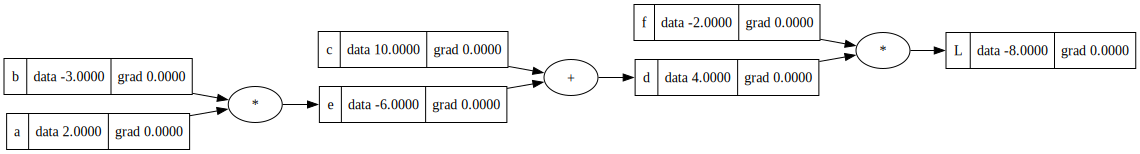

In [34]:
def trace(root):
    """Build a set of all nodes and edges in the graph"""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """Create a Graphviz visualization of the computational graph"""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a node for each Value
        dot.node(name=uid, 
                 label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
                 shape='record')
        if n._op:
            # Create an operation node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect input to operation
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# Visualize before backpropagation
print("Computational Graph (before backprop - all gradients are 0):")
draw_dot(L)

---
## Part 4: The Chain Rule - The Heart of Backpropagation

The **chain rule** is the key mathematical principle behind backpropagation:

$$\frac{dL}{dx} = \frac{dL}{dy} \cdot \frac{dy}{dx}$$

In words: *"The rate of change of L with respect to x equals the rate of change of L with respect to y, multiplied by the rate of change of y with respect to x."*

### Let's Apply It Step by Step

Starting from the output $L$ and working backwards:

1. **$L$ with respect to itself**: $\frac{dL}{dL} = 1$ (trivially true)

2. **$L = d \cdot f$**, so:
   - $\frac{dL}{dd} = f = -2$
   - $\frac{dL}{df} = d = 4$

3. **$d = e + c$**, so:
   - $\frac{dd}{de} = 1$
   - $\frac{dd}{dc} = 1$
   - By chain rule: $\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de} = -2 \cdot 1 = -2$
   - By chain rule: $\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc} = -2 \cdot 1 = -2$

4. **$e = a \cdot b$**, so:
   - $\frac{de}{da} = b = -3$
   - $\frac{de}{db} = a = 2$
   - By chain rule: $\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da} = -2 \cdot (-3) = 6$
   - By chain rule: $\frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{db} = -2 \cdot 2 = -4$

In [35]:
# Let's verify this manually step by step
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

e = a * b;  e.label = 'e'
d = e + c;  d.label = 'd'
L = d * f;  L.label = 'L'

print("=== MANUAL BACKPROPAGATION ===")
print()

# Step 1: dL/dL = 1
L.grad = 1.0
print(f"Step 1: dL/dL = {L.grad}")

# Step 2: L = d * f
# dL/dd = f = -2
# dL/df = d = 4
d.grad = f.data * L.grad  # = -2 * 1 = -2
f.grad = d.data * L.grad  # = 4 * 1 = 4
print(f"Step 2: L = d * f")
print(f"        dL/dd = f * (dL/dL) = {f.data} * {L.grad} = {d.grad}")
print(f"        dL/df = d * (dL/dL) = {d.data} * {L.grad} = {f.grad}")

# Step 3: d = e + c
# dL/de = dL/dd * dd/de = dL/dd * 1
# dL/dc = dL/dd * dd/dc = dL/dd * 1
e.grad = 1.0 * d.grad  # = 1 * -2 = -2
c.grad = 1.0 * d.grad  # = 1 * -2 = -2
print(f"Step 3: d = e + c")
print(f"        dL/de = 1 * (dL/dd) = 1 * {d.grad} = {e.grad}")
print(f"        dL/dc = 1 * (dL/dd) = 1 * {d.grad} = {c.grad}")

# Step 4: e = a * b
# dL/da = dL/de * de/da = dL/de * b
# dL/db = dL/de * de/db = dL/de * a
a.grad = b.data * e.grad  # = -3 * -2 = 6
b.grad = a.data * e.grad  # = 2 * -2 = -4
print(f"Step 4: e = a * b")
print(f"        dL/da = b * (dL/de) = {b.data} * {e.grad} = {a.grad}")
print(f"        dL/db = a * (dL/de) = {a.data} * {e.grad} = {b.grad}")

print()
print("=== FINAL GRADIENTS ===")
print(f"dL/da = {a.grad}")
print(f"dL/db = {b.grad}")
print(f"dL/dc = {c.grad}")
print(f"dL/df = {f.grad}")

=== MANUAL BACKPROPAGATION ===

Step 1: dL/dL = 1.0
Step 2: L = d * f
        dL/dd = f * (dL/dL) = -2.0 * 1.0 = -2.0
        dL/df = d * (dL/dL) = 4.0 * 1.0 = 4.0
Step 3: d = e + c
        dL/de = 1 * (dL/dd) = 1 * -2.0 = -2.0
        dL/dc = 1 * (dL/dd) = 1 * -2.0 = -2.0
Step 4: e = a * b
        dL/da = b * (dL/de) = -3.0 * -2.0 = 6.0
        dL/db = a * (dL/de) = 2.0 * -2.0 = -4.0

=== FINAL GRADIENTS ===
dL/da = 6.0
dL/db = -4.0
dL/dc = -2.0
dL/df = 4.0


Computational Graph (after manual backprop):


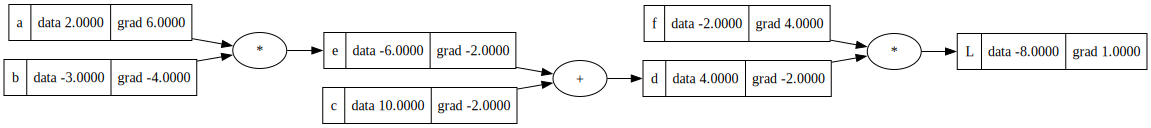

In [37]:
# Visualize with gradients
print("Computational Graph (after manual backprop):")
draw_dot(L)

### Verification: Compare Manual vs Numerical Gradients

In [38]:
print("Comparing manual backprop vs numerical derivatives:")
print()
print(f"Variable | Manual Gradient | Numerical Gradient | Match?")
print("-" * 60)

variables = [('a', a.grad, dL_da), ('b', b.grad, dL_db), 
             ('c', c.grad, dL_dc), ('f', f.grad, dL_df)]

for name, manual, numerical in variables:
    match = "✓" if abs(manual - numerical) < 0.01 else "✗"
    print(f"{name}        | {manual:15.4f} | {numerical:17.4f} | {match}")

Comparing manual backprop vs numerical derivatives:

Variable | Manual Gradient | Numerical Gradient | Match?
------------------------------------------------------------
a        |          6.0000 |            6.0000 | ✓
b        |         -4.0000 |           -4.0000 | ✓
c        |         -2.0000 |           -2.0000 | ✓
f        |          4.0000 |            4.0000 | ✓


---
## Part 5: Automatic Backpropagation

The manual process is error-prone. Let's automate it!

The key insight is that we need to process nodes in **reverse topological order** - start from the output and work backwards, ensuring each node is processed only after all nodes that depend on it.

In [39]:
class Value:
    """
    Enhanced Value class with automatic backpropagation.
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        """Hyperbolic tangent activation function"""
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        # Derivative of tanh: d(tanh(x))/dx = 1 - tanh(x)²
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        """
        Automatic backpropagation!
        
        1. Build a topological ordering of the graph
        2. Set output gradient to 1
        3. Call _backward() on each node in reverse order
        """
        # Build topological order
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        # Set output gradient and backpropagate
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

=== AUTOMATIC BACKPROPAGATION RESULTS ===
L = -8.0
dL/da = 6.0
dL/db = -4.0
dL/dc = -2.0
dL/df = 4.0


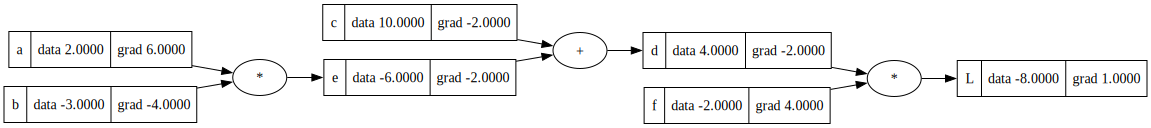

In [40]:
# Test automatic backpropagation
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

e = a * b;  e.label = 'e'
d = e + c;  d.label = 'd'
L = d * f;  L.label = 'L'

# One call does everything!
L.backward()

print("=== AUTOMATIC BACKPROPAGATION RESULTS ===")
print(f"L = {L.data}")
print(f"dL/da = {a.grad}")
print(f"dL/db = {b.grad}")
print(f"dL/dc = {c.grad}")
print(f"dL/df = {f.grad}")

draw_dot(L)

---
## Part 6: A Neural Network Example

Let's apply what we've learned to a simple **neuron** - the building block of neural networks.

A neuron computes:
$$o = \tanh(x_1 w_1 + x_2 w_2 + b)$$

Where:
- $x_1, x_2$ are inputs
- $w_1, w_2$ are weights (what we want to learn!)
- $b$ is a bias
- $\tanh$ is the activation function

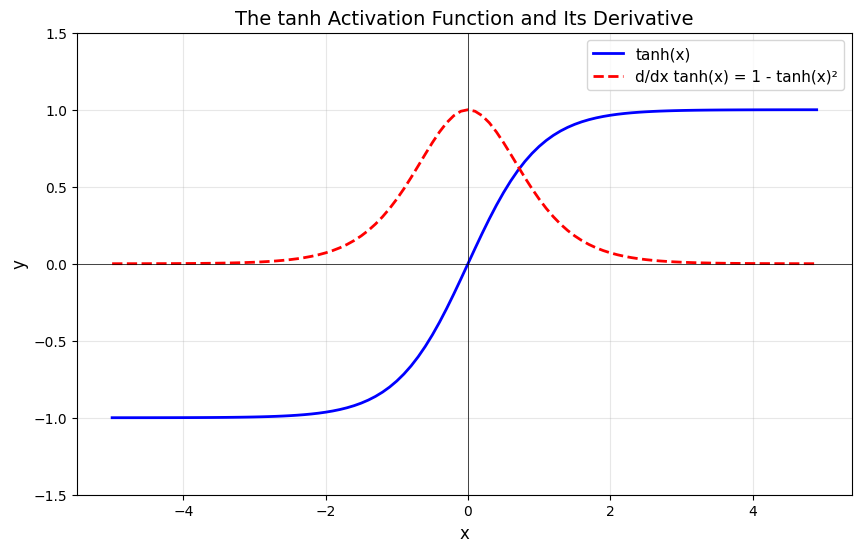

In [41]:
# Visualize tanh
x_range = np.arange(-5, 5, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_range, np.tanh(x_range), 'b-', linewidth=2, label='tanh(x)')
plt.plot(x_range, 1 - np.tanh(x_range)**2, 'r--', linewidth=2, label="d/dx tanh(x) = 1 - tanh(x)²")
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('The tanh Activation Function and Its Derivative', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.ylim(-1.5, 1.5)
plt.show()

In [42]:
# Build a single neuron
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias (chosen to make the math work out nicely)
b = Value(6.8813735870195432, label='b')

# Forward pass
x1w1 = x1 * w1;              x1w1.label = 'x1*w1'
x2w2 = x2 * w2;              x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;      x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b;            n.label = 'n'
o = n.tanh();                o.label = 'o'

print(f"Neuron output: o = {o.data:.4f}")
print(f"(This equals tanh(x1*w1 + x2*w2 + b) = tanh({n.data:.4f}) ≈ {math.tanh(n.data):.4f})")

Neuron output: o = 0.7071
(This equals tanh(x1*w1 + x2*w2 + b) = tanh(0.8814) ≈ 0.7071)


In [43]:
# Backpropagate!
o.backward()

print("=== NEURON GRADIENTS ===")
print(f"\nInputs:")
print(f"  x1: data={x1.data:.4f}, grad={x1.grad:.4f}")
print(f"  x2: data={x2.data:.4f}, grad={x2.grad:.4f}")

print(f"\nWeights (these are what we'd update during training!):")
print(f"  w1: data={w1.data:.4f}, grad={w1.grad:.4f}")
print(f"  w2: data={w2.data:.4f}, grad={w2.grad:.4f}")

print(f"\nBias:")
print(f"  b:  data={b.data:.4f}, grad={b.grad:.4f}")

=== NEURON GRADIENTS ===

Inputs:
  x1: data=2.0000, grad=-1.5000
  x2: data=0.0000, grad=0.5000

Weights (these are what we'd update during training!):
  w1: data=-3.0000, grad=1.0000
  w2: data=1.0000, grad=0.0000

Bias:
  b:  data=6.8814, grad=0.5000


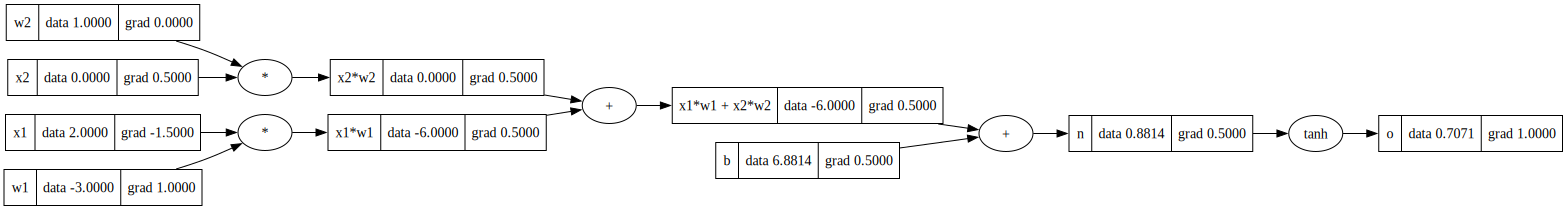

In [44]:
# Visualize the full computational graph
draw_dot(o)

---
## Part 7: Using Gradients to Optimize

Now we know how each weight affects the output! We can use this to **change the weights** to make the output what we want.

This is **gradient descent**:
$$w_{new} = w_{old} - \alpha \cdot \frac{\partial L}{\partial w}$$

Where $\alpha$ is the **learning rate** (how big our steps are).

In [45]:
# Let's make a simple example: we want L = (a*b + c) * f to be MINIMIZED

print("Optimizing L = (a*b + c) * f to minimize it")
print("=" * 50)

# Initial values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

learning_rate = 0.01
history = []

for step in range(50):
    # Forward pass
    e = a * b
    d = e + c
    L = d * f
    
    # Record
    history.append(L.data)
    
    if step % 10 == 0:
        print(f"Step {step:3d}: L = {L.data:8.4f}, a={a.data:.4f}, b={b.data:.4f}, c={c.data:.4f}, f={f.data:.4f}")
    
    # Backward pass
    L.backward()
    
    # Update all values using gradients (gradient descent)
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad
    c.data -= learning_rate * c.grad
    f.data -= learning_rate * f.grad
    
    # Reset gradients for next iteration (important!)
    a.grad = 0.0
    b.grad = 0.0
    c.grad = 0.0
    f.grad = 0.0

print(f"\nFinal: L = {L.data:.4f}")

Optimizing L = (a*b + c) * f to minimize it
Step   0: L =  -8.0000, a=2.0000, b=-3.0000, c=10.0000, f=-2.0000
Step  10: L = -16.6684, a=1.3765, b=-2.6211, c=10.2213, f=-2.5204
Step  20: L = -29.4070, a=0.6734, b=-2.3213, c=10.5059, f=-3.2884
Step  30: L = -48.1313, a=-0.1618, b=-2.2120, c=10.8777, f=-4.2839
Step  40: L = -80.7780, a=-1.2755, b=-2.5261, c=11.3600, f=-5.5395

Final: L = -159.1893


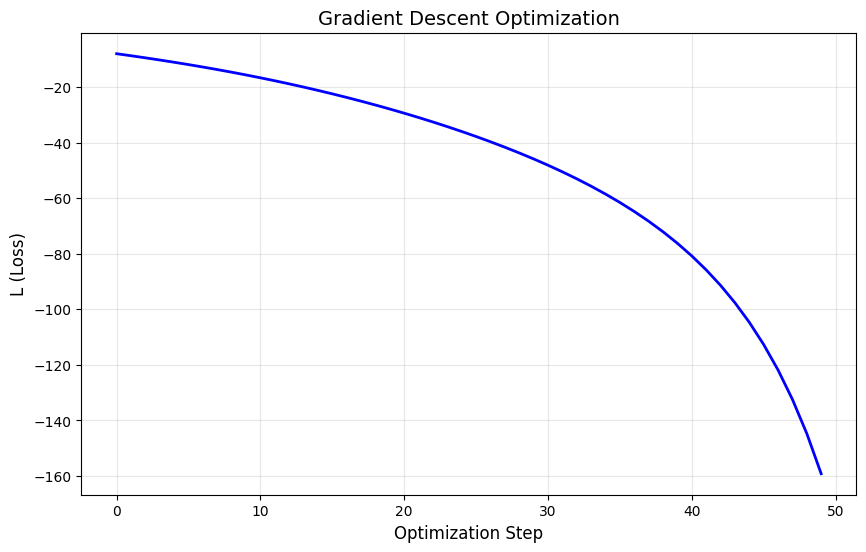

In [46]:
# Plot the optimization trajectory
plt.figure(figsize=(10, 6))
plt.plot(history, 'b-', linewidth=2)
plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('L (Loss)', fontsize=12)
plt.title('Gradient Descent Optimization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

---
## Part 8: Handling Edge Cases - Variable Reuse

What happens when a variable is used multiple times? The chain rule handles this - gradients **accumulate**.

For $b = a + a$, we have $\frac{db}{da} = 2$ (not 1!)

b = a + a = 6.0
db/da = 2.0  (should be 2, not 1!)


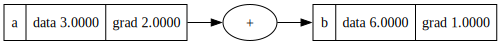

In [47]:
# Example: b = a + a
a = Value(3.0, label='a')
b = a + a
b.label = 'b'

b.backward()

print(f"b = a + a = {b.data}")
print(f"db/da = {a.grad}  (should be 2, not 1!)")

draw_dot(b)

f = (a*b) * (a+b) = -6.0
df/da = -3.0 (expected: -3)
df/db = -8.0 (expected: -8)


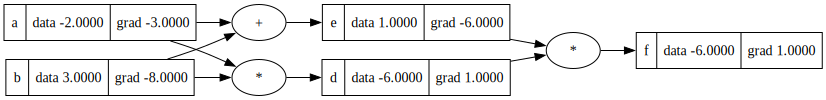

In [48]:
# More complex example
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b;    d.label = 'd'
e = a + b;    e.label = 'e'
f = d * e;    f.label = 'f'

# f = (a * b) * (a + b) = a²b + ab²
# df/da = 2ab + b² = 2(-2)(3) + 9 = -12 + 9 = -3
# df/db = a² + 2ab = 4 + 2(-2)(3) = 4 - 12 = -8

f.backward()

print(f"f = (a*b) * (a+b) = {f.data}")
print(f"df/da = {a.grad} (expected: -3)")
print(f"df/db = {b.grad} (expected: -8)")

draw_dot(f)

---
## Summary: Key Takeaways

### Computational Graphs
- Every computation can be represented as a **graph** of operations
- Nodes hold values, edges represent data flow

### The Chain Rule
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x}$$
- Allows us to compute gradients by breaking down complex expressions
- Each node only needs to know its **local derivative**

### Backpropagation
- Start from the output (gradient = 1)
- Work backwards through the graph
- Multiply local gradients along the way
- **Accumulate** gradients when variables are reused

### Gradient Descent
$$w_{new} = w_{old} - \alpha \cdot \frac{\partial L}{\partial w}$$
- Use gradients to update parameters
- Move in the **opposite direction** of the gradient to minimize loss

### This is exactly how modern deep learning frameworks (PyTorch, TensorFlow) work!

The main differences are:
- They work with **tensors** (multi-dimensional arrays) instead of scalars
- They have many more operations implemented
- They're optimized for GPU computation

---
## Exercises

1. **Extend the Value class** to support subtraction and division
2. **Add more activation functions** like ReLU: `max(0, x)` and sigmoid: `1 / (1 + e^(-x))`
3. **Build a 2-layer neural network** using the Value class
4. **Train the network** to learn XOR (a classic neural network test)

In [31]:
# Exercise space - try implementing the extensions!

# Hint for subtraction: a - b = a + (-1 * b)
# Hint for division: a / b = a * (b ** -1)
# Hint for ReLU derivative: 1 if x > 0, else 0